In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as backend
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

In [3]:
def seed_everything(seed=176):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(30)

In [38]:
base_dir = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

In [39]:
tr = pd.read_csv(base_dir+"/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(base_dir+"/test.csv")

# add info
sub = pd.read_csv(base_dir+"/sample_submission.csv")
#print(sub.head(5), '\n')
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
#print(sub.head(5), '\n')
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
#print(sub.head(5), '\n')
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
#print(sub.head(5), '\n')
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")
print(sub.head(5), '\n')

                     Patient  Weeks  Confidence  \
0  ID00419637202311204720264    -12         100   
1  ID00419637202311204720264    -11         100   
2  ID00419637202311204720264    -10         100   
3  ID00419637202311204720264     -9         100   
4  ID00419637202311204720264     -8         100   

                    Patient_Week   FVC    Percent  Age   Sex SmokingStatus  
0  ID00419637202311204720264_-12  3020  70.186855   73  Male     Ex-smoker  
1  ID00419637202311204720264_-11  3020  70.186855   73  Male     Ex-smoker  
2  ID00419637202311204720264_-10  3020  70.186855   73  Male     Ex-smoker  
3   ID00419637202311204720264_-9  3020  70.186855   73  Male     Ex-smoker  
4   ID00419637202311204720264_-8  3020  70.186855   73  Male     Ex-smoker   



In [40]:
# combine training, validation, and test data into one dataframe with new column 'WHERE' specifying train, validation, or test
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

print(data.head(5))

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   WHERE  Confidence Patient_Week  
0  train         NaN          NaN  
1  train         NaN          NaN  
2  train         NaN          NaN  
3  train         NaN          NaN  
4  train         NaN          NaN  


In [41]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print('number of unique patients in training set: ', tr.Patient.nunique())
print('number of unique patients in validation set: ', chunk.Patient.nunique())
print('number of unique patients in test set: ', sub.Patient.nunique())
print('number of unique patients in data: ', data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
number of unique patients in training set:  176
number of unique patients in validation set:  5
number of unique patients in test set:  5
number of unique patients in data:  176


In [42]:
# make all test set 'min_week' = NAN
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan

# giving each data row a min_week column that is equal to the smallest 'Weeks' for that patient id
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [43]:
# create base FVC (similar to min week)
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1

# count any duplicates and only select samples with none?
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [44]:
# merge base and data by matching Patient numbers
data = data.merge(base, on='Patient', how='left')

# create time difference between min and current week
data['base_week'] = data['Weeks'] - data['min_week']

del base

In [45]:
# one hot encode necessary columns

COLS = ['Sex','SmokingStatus']
FE = []  # list of column names that will be used for analysis
for col in COLS:
    for mod in data[col].unique():
        
        # keep column unique column names in FE
        FE.append(mod)
        
        # create new column with column name and value of 0 or 1 if col==mod (i.e. Ex-smoker == Ex-smoker is value of 1 
        # and Ex-Smoker == Never smoked is value of 0)
        data[mod] = (data[col] == mod).astype(int)

print(data.head(5))

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   WHERE  Confidence Patient_Week  min_week  min_FVC  base_week  Male  Female  \
0  train         NaN          NaN      -4.0     2315        0.0     1       0   
1  train         NaN          NaN      -4.0     2315        9.0     1       0   
2  train         NaN          NaN      -4.0     2315       11.0     1       0   
3  train         NaN          NaN      -4.0     2315       13.0     1       0   
4  train         NaN          NaN      -4.0     2315       15.0     1       0   

   Ex-smoker  Never smoked

In [48]:
# normalize using min and max of each column (this creates new columns age, BASE, week, percent)
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [49]:
# split into training, validation, and test

tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [50]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

### BASELINE NN 

In [67]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

#=============================#
# the metric for scoring defined by the Fibrosis challenge
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return backend.mean(metric)

#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.18394, 0.50, 0.81606]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return backend.mean(v)

#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

#=================

# UNDERSTAND WHAT IS GOING ON HERE
def make_model(nh):
    z = layers.Input((nh,), name="Patient")
    x = layers.Dense(128, activation="relu", name="d1")(z)
    x = layers.Dense(128, activation="relu", name="d2")(x)
    #x = layers.Dense(64, activation="relu", name="d3")(x)
    p1 = layers.Dense(3, activation="linear", name="p1")(x)
    p2 = layers.Dense(3, activation="relu", name="p2")(x)
    preds = layers.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model1 = models.Model(z, preds, name="CNN")
    opt = tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
    model1.compile(loss=mloss(0.8), optimizer=opt, metrics=[score])
    return model1

In [68]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values

# number of parameters in the model (i.e. number of columns)
nh = z.shape[1]
print('number of columns (parameters):', nh)

pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

number of columns (parameters): 9


In [69]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [85]:
# K-Folds cross-validator: Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds

NFOLD = 10
kf = KFold(n_splits=NFOLD)

In [71]:
%%time
cnt = 0
EPOCHS = 800

# train data on a bunch of different split folds (NFOLD number of them)
for tr_idx, val_idx in kf.split(z):
    
    cnt += 1
    print(f"FOLD {cnt}")
    
    # make model for new split
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(z[val_idx], y[val_idx]), verbose=0)
    
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    
    # sum all the fold predictions and divide by number of folds
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD
#==============

FOLD 1
train [37.53284454345703, 6.43090295791626]
val [44.04368209838867, 6.711625576019287]
predict val...
predict test...
FOLD 2
train [40.199771881103516, 6.512215614318848]
val [44.89497756958008, 6.614282608032227]
predict val...
predict test...
FOLD 3
train [38.60685729980469, 6.456079006195068]
val [55.25197219848633, 6.731064319610596]
predict val...
predict test...
FOLD 4
train [40.72381591796875, 6.527632713317871]
val [40.22521209716797, 6.473474025726318]
predict val...
predict test...
FOLD 5
train [39.862892150878906, 6.506923675537109]
val [54.03593826293945, 6.78908109664917]
predict val...
predict test...
CPU times: user 5min 25s, sys: 32.7 s, total: 5min 58s
Wall time: 4min 14s


In [72]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

139.99393290665716 231.45372572908184


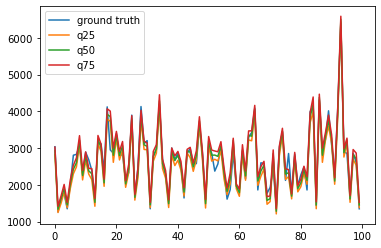

In [73]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [74]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

58.40283203125 231.45372572908184 456.3896484375 1.0


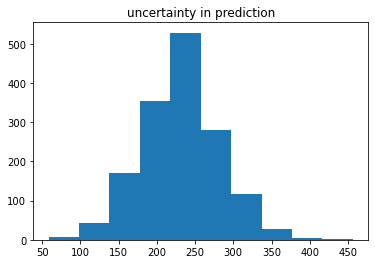

In [75]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

### PREDICTION

In [76]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [77]:
sub['FVC1'] = 0.996*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [78]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [79]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2868.270575,223.316162
1541,ID00419637202311204720264_-11,3020,100.0,2865.954376,224.567078
1542,ID00419637202311204720264_-10,3020,100.0,2863.638178,225.817871
1543,ID00419637202311204720264_-9,3020,100.0,2861.321676,227.068848
1544,ID00419637202311204720264_-8,3020,100.0,2859.005416,228.319763
1545,ID00419637202311204720264_-7,3020,100.0,2856.689096,229.570435
1546,ID00419637202311204720264_-6,3020,100.0,2854.372837,230.821411
1547,ID00419637202311204720264_-5,3020,100.0,2852.056578,232.072266
1548,ID00419637202311204720264_-4,3020,100.0,2849.718190,233.419067
1549,ID00419637202311204720264_-3,3020,100.0,2847.351353,234.888794


In [80]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [81]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2868.270575,223.316162,2868.270575,223.316162
1541,ID00419637202311204720264_-11,2865.954376,224.567078,2865.954376,224.567078
1542,ID00419637202311204720264_-10,2863.638178,225.817871,2863.638178,225.817871
1543,ID00419637202311204720264_-9,2861.321676,227.068848,2861.321676,227.068848
1544,ID00419637202311204720264_-8,2859.005416,228.319763,2859.005416,228.319763


In [82]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2647.005395,323.309396,1992.262587,2579.431639,2692.518034,2821.362236,3209.325255
Confidence,730.0,290.843300,57.973847,168.986145,243.517044,292.177994,338.271820,404.420441
FVC1,730.0,2647.005395,323.309396,1992.262587,2579.431639,2692.518034,2821.362236,3209.325255
Confidence1,730.0,290.843300,57.973847,168.986145,243.517044,292.177994,338.271820,404.420441


In [83]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [84]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)